In [1]:
import pydicom,kornia,skimage
from fastai.vision.all import *
from fastai.medical.imaging import *
from torchvision.utils import save_image
import seaborn as sns

from fmi.pipeline import *
from fmi.explore import *
from fmi.preprocessing import *
from fmi.examine import *
from itertools import chain
import imageio
from sklearn.model_selection import train_test_split

import timm
from wwf.vision.timm import *

matplotlib.rcParams['image.cmap'] = 'bone'

In [2]:
source = untar_data(URLs.SIIM_SMALL)
p_items = get_dicom_files(f'{source}/train')
df = pd.read_csv(f'{source}/labels.csv')
p_items

(#250) [Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000000.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000002.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000005.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000006.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000007.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000008.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000009.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000011.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000012.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/train/No Pneumothorax/000014.dcm')...]

`system_info` conveniently lists the current `fastai`, `fastcore`versions as well as `cuda`, `pydicom` and `kornia` versions

In [4]:
system_info()

fastai Version: 2.2.5
fastcore Version: 1.3.19
python Version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
torchvision: 0.8.1
torch version: 1.7.0

Cuda: True
cuda Version: 11.0
GPU: GeForce GTX 1060

pydicom Version: 2.1.1
kornia Version: 0.2.0


Dicom metadata contains a wealth of information like the example below.

In [16]:
p_items[0].dcmread()

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

However sometimes it is better to get more targeted information from the metadata.

`get_image_info` provides image specific information such as the Modality, Photometric Interpretation, Pixel Spacing, SliceThickness, Bits Allocated, RescaleIntercept and RescaleSlope.  This information is important when modelling the data.

In [5]:
get_image_info(p_items[0])

(0008, 0060) Modality                            CS: 'CR'
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0030) Pixel Spacing                       DS: [0.168, 0.168]
No SliceThickness
(0028, 0100) Bits Allocated                      US: 8
No Rescale Intercept
No Rescale Slope


When dealing with medical based datasets it is important to know if there are any patient identifiable identifiers within the metadata.  This information if present is important to consider because it may reveal additional information as well as potential bias.  `get_pii` conveniently lists this information as well as looking for the `Image Comments` tag within the metadata that may contain useful information

In [6]:
get_pii(p_items[0])

(0010, 0010) Patient's Name                      PN: '16d7f894-55d7-4d95-8957-d18987f0e981'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '62'
No Image Comments


### Splitting the Data

It is common practice to split the dataset into train and valid, for example RandomSplitter splits the data with a 80:20 split. However it is also important to ensure that the same patient is not present in both the train and valid splits

In [19]:
trn,val = RandomSplitter()(p_items)

In [20]:
trn, val

((#200) [143,74,246,160,237,192,152,196,25,97...],
 (#50) [115,188,69,43,89,60,215,65,40,80...])

The SIIM_SMALL only contains 250 images and you can easily check if duplicates exist when splitting the data by using `check_duplicates` and specifying a seed value.

Train: 200 
 Original Validation: 50 
 Updated Validation: 50


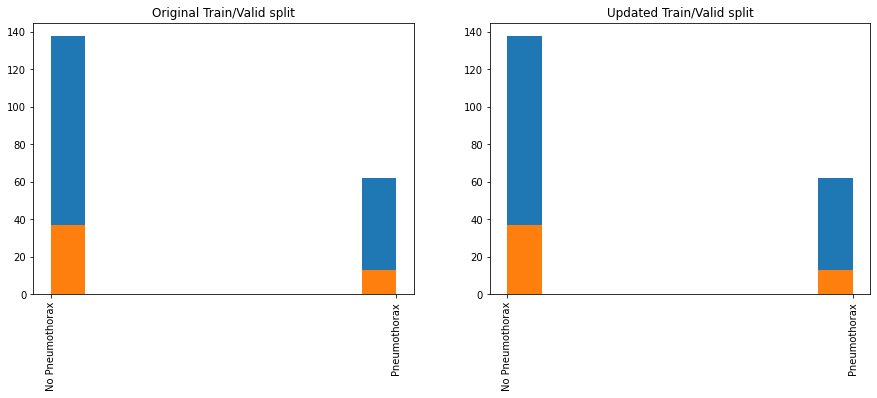

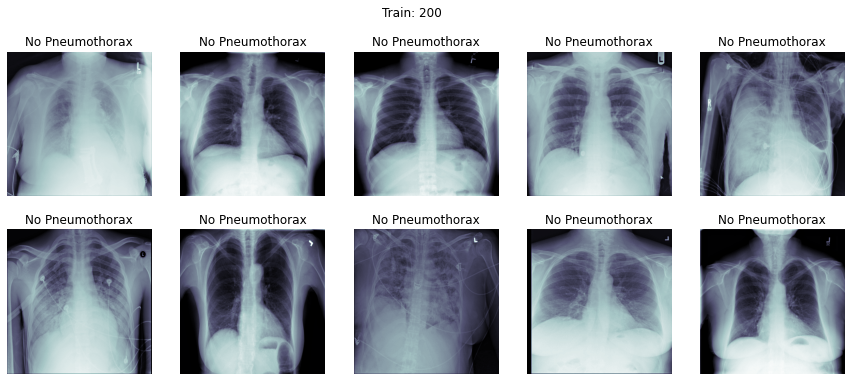

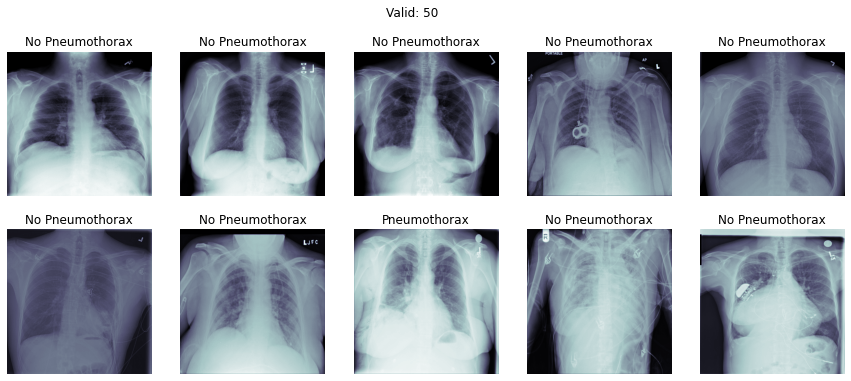

In [8]:
check_duplicate(p_items, valid_pct=0.2, seed=78)

`check_duplicates` displays the number of train and valid images and if there are duplicates it will also display the updated valid count with the duplicates removed from the valid set.  It also displays images from the train and valid sets

The dataset as is does not have any duplicate images and hence the reason why the updated valid count is the same as the original valid count.

**What happens when there is/are duplicates in the train and valid sets?**

To see what happens I have another dataset that contains duplicate images (using a dataset with known duplicates)

In [14]:
dup_items = get_dicom_files(f'{source}/sm')
dup_items

(#357) [Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000000.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000002.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000005.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000006.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000007.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000008.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000009.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000011.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000012.dcm'),Path('C:/Users/avird/.fastai/data/siim_small/sm/No Pneumothorax/000014.dcm')...]

Train: 286 
 Original Validation: 71 
 Updated Validation: 30


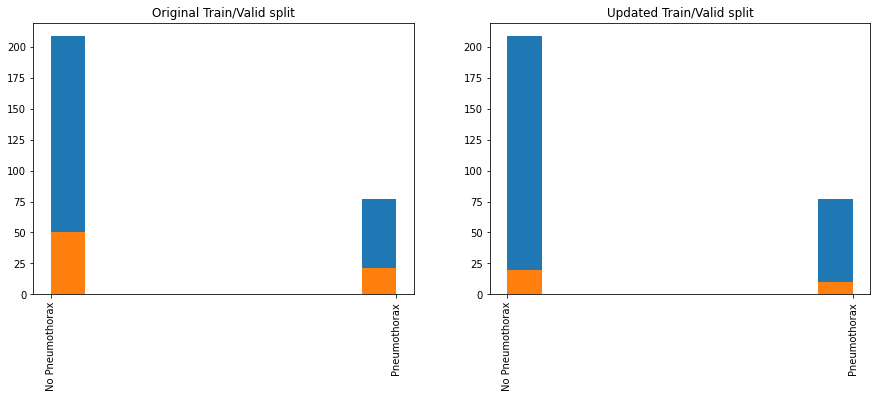

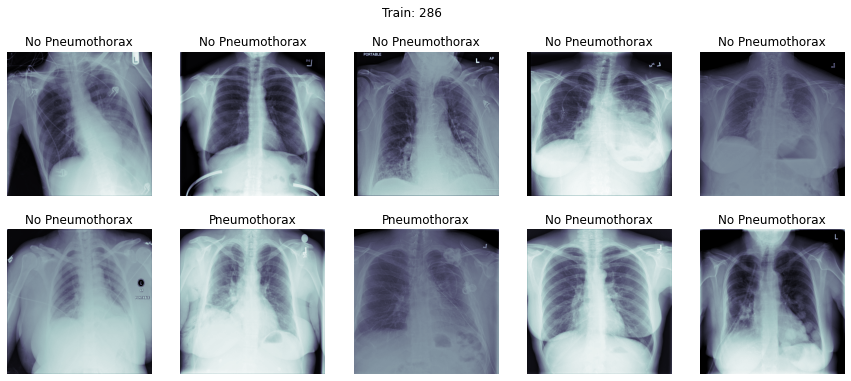

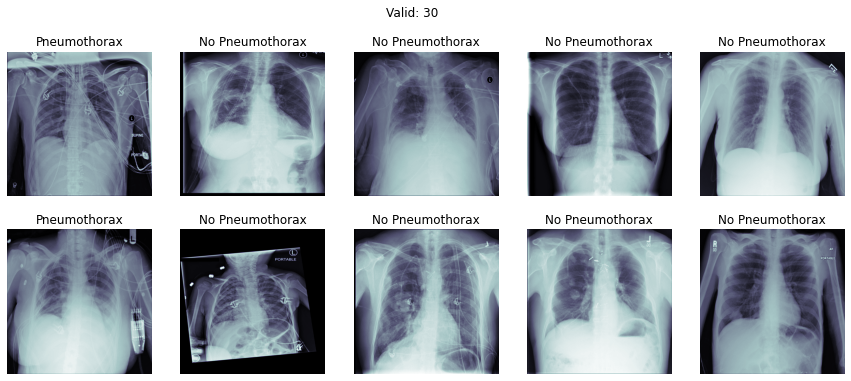

In [15]:
check_duplicate(dup_items, valid_pct=0.2, seed=7)

In this case the original split had 286 images in the train set and 71 images in the validation set. `check_duplicates` was able to find 41 duplicates in the validation set and removes them from here hence the updated validation count of 30.  However we now know that there are no duplicate patients in the train and validation sets

`dicom_splitter` uses the same methodology and this can be passed when creating the `DataBlock`

In [18]:
splitter = dicom_splitter(p_items, valid_pct=0.2, seed=7)
splitter

<function fmi.preprocessing.dicom_splitter.<locals>._inner(o)>

In [19]:
item_tfms = Resize(266)
batch_tfms = [RandomResizedCropGPU(226), *aug_transforms(do_flip=False, flip_vert=False, max_rotate=10.,
                                                         min_zoom=1., max_zoom=1.1, max_lighting=0.2, max_warp=0.1),
                                                         Normalize.from_stats(*imagenet_stats)]

In [22]:
set_seed(7)
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:source/f"{x[0]}",
                   get_y=lambda x:x[1],
                   splitter=splitter,
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms)

In [23]:
set_seed(7)
dls = pneumothorax.dataloaders(df.values, bs=5, num_workers=0)

200 50


As we are using the original `SIMM_SMALL` dataset the train and valid counts are 200 and 50 respectively

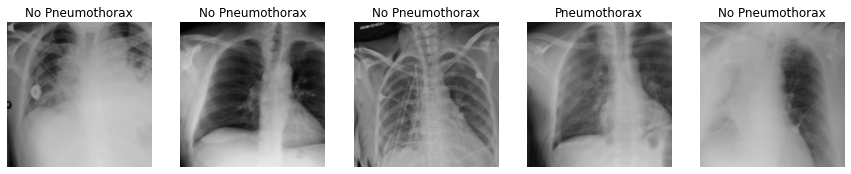

In [24]:
dls.show_batch(nrows=1)

In [25]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, cbs=[SaveModelCallback, ShowGraphCallback])

epoch,train_loss,valid_loss,accuracy,time
0,1.196685,0.784941,0.620000,00:12
1,1.179904,0.825156,0.660000,00:09
2,1.027421,0.581181,0.680000,00:09
3,0.962743,0.585098,0.700000,00:09
4,0.830980,0.579057,0.720000,00:09


Better model found at epoch 0 with valid_loss value: 0.7849407196044922.


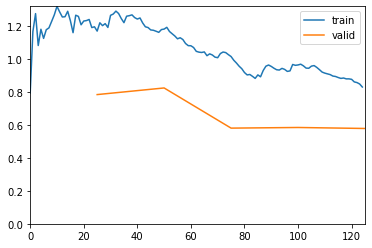

Better model found at epoch 2 with valid_loss value: 0.5811811685562134.
Better model found at epoch 4 with valid_loss value: 0.5790573358535767.


In [27]:
learn.fit_one_cycle(5)

In [28]:
learn.save('one')

Path('models/one.pth')

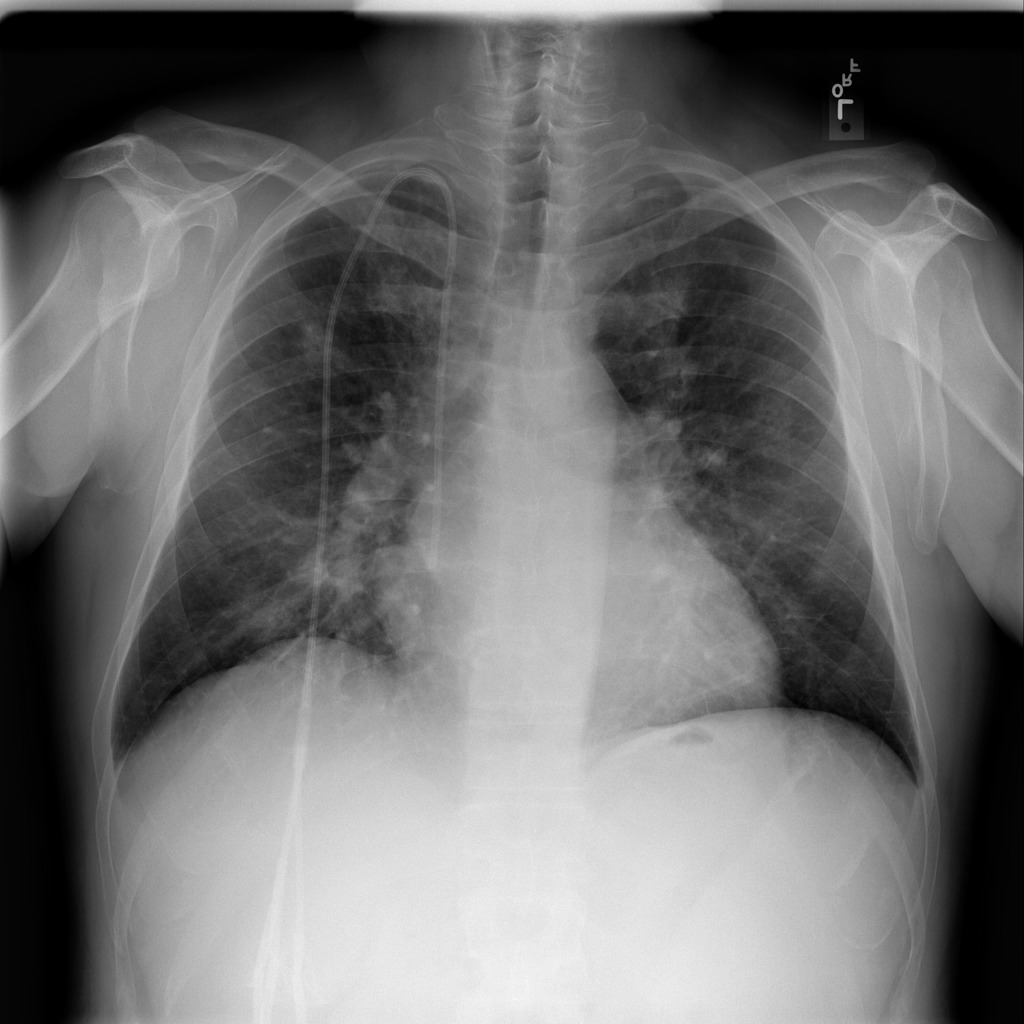

In [29]:
test_image = PILDicom.create(p_items[97])
test_image

In [30]:
learn.model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Number of Layers: 90


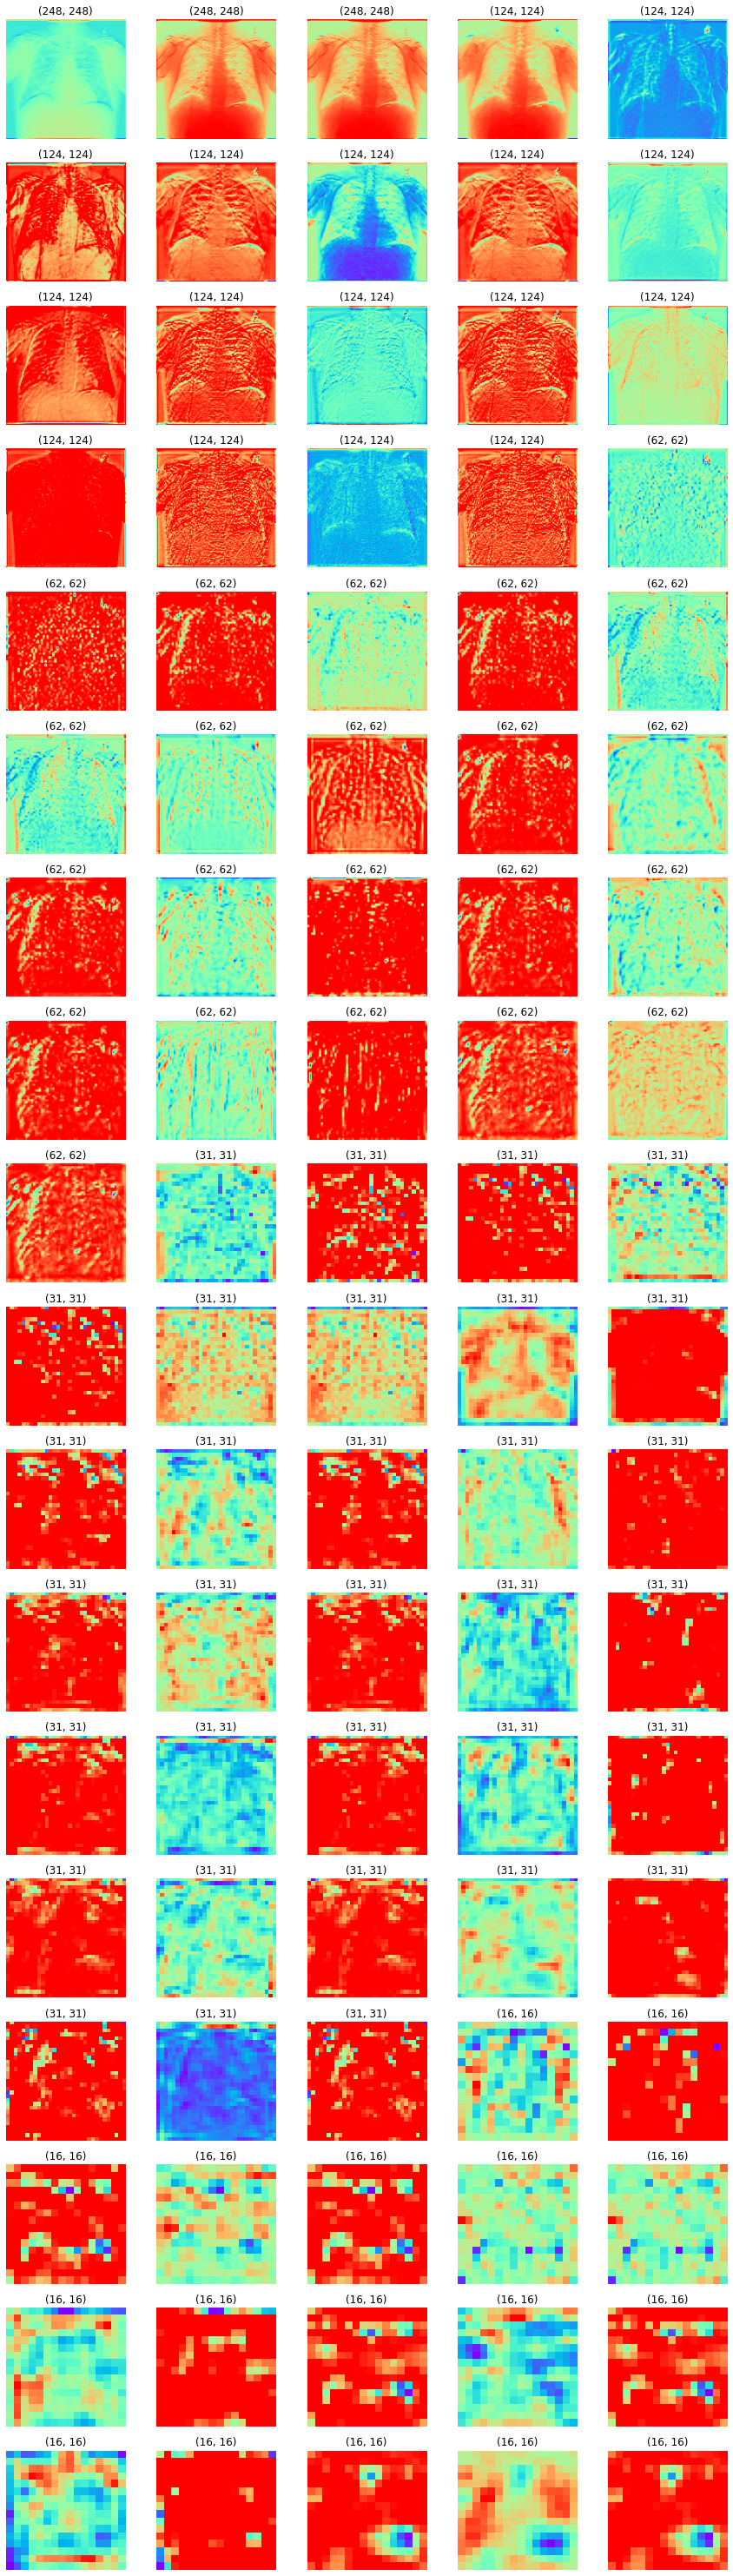

In [32]:
matplotlib.rcParams['image.cmap'] = 'rainbow_r'
visualize_layers(p_items[97], learn, nrows=18, ncols=5)